# Toxic Comments Classification

In this program, we are going to classify a comment in 6 different labels such as *toxic, severe_toxic, obsene*, etc.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, GlobalAvgPool1D, Dropout, Embedding,Bidirectional, Flatten, CuDNNLSTM, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Getting the dataset

In [2]:
training_set = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")

In [3]:
training_set = training_set.drop(['id'], axis=1)

## Analyzing the dataset

In [4]:
print("Number of training records :",len(training_set))
print("Columns :")
for i in training_set:
    print("\t"+i)

Number of training records : 159571
Columns :
	comment_text
	toxic
	severe_toxic
	obscene
	threat
	insult
	identity_hate


The training set consists of 159571 records and 8 columns. The columns are very much self explanatory.<br>
<br>
>The **id** contains the id of our training records and is quite irrelevant for the training purpose, so we will eventually end up dropping this column.<br>
>Then we have **comment_text**, which consists of the text of comment text.<br>
>Rest other columns have values 0/1 based on whether the comment text qualifies for that label.
<br>


**Now, let's take a look at how many examples of training data do we have satifying our labels.**

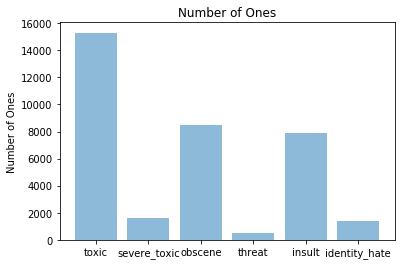

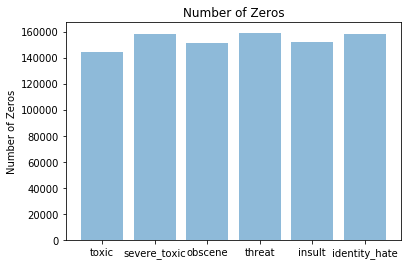

In [5]:
#plot 2
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']  
count_ones = []
for i in columns:
    count_ones.append(training_set[training_set[i]==1][i].count())
y_pos = np.arange(len(columns))
plt.bar(y_pos, count_ones, align="center", alpha=0.5)
plt.xticks(y_pos, columns)
plt.ylabel("Number of Ones")
plt.title("Number of Ones")
plt.show()

#plot 1
count_zeros = []
for i in columns:
    count_zeros.append(training_set[training_set[i]==0][i].count())
y_pos = np.arange(len(columns))
plt.bar(y_pos, count_zeros, align="center", alpha=0.5)
plt.xticks(y_pos, columns)
plt.ylabel("Number of Zeros")
plt.title("Number of Zeros")
plt.show()

From the above plots, we can see that our training set has more records which are negative(or have '0' value). We have around 15000 records which have are positively classified as toxic and around 140000 which are classified as negative. The worst case is with the threat class, here we have aroung 500-700 positive records only, while having 160000 negative records. So, our data is could be highly biased towards predicting a comment as negative toxicity for most of the classes.

**Let's have a look at some of the data examples.**

In [6]:
for i in range(1):
    j = random.randint(0, 10000)
    print(training_set.values[j])
    

['"\n\n Zora and Aiden, You, being Non-Muslims, assume being all-knowing about Islam and consider me as an ignorant Muslims who misinterprets his religion. Thanks really for your kind attitude. I was talking at an scholarly level, quoting verses from Qur\'an; You can not revert my edits wholesale just because you don\'t like them and post your own interpretation there. I don\'t like to get into a revert war though I am pretty sure that my edits are quite justified and I will be the one who will eventually win the debate. You can always add the POV tag to the section and try to find the opinion of other scholars or quote other qur\'anic verses. Regarding your point; doing ""original research"", I would like to say that it is just an excuse and maybe a good strategy to quite the beginners. If we REALLY don\'t want to do ANY original research, many parts of many articles in wikipedia should be deleted. All the articles will become mere quotes from several scholars without any glue to keep

**Okay, so enough of analyzing the data. Now, let's preprocess our data for training.**

Since, we have text data and the semantics of text are very important to correctly classify them as being toxic, severe_toxic, and so on, we will be using pre-trained word embeddings as inputs.

## Getting Word Embeddings

In [7]:
f = open("../input/glove-embeddings/glove.6B.300d.txt")

In [8]:
embedding_matrix = {}
for line in tqdm(f):
    temp = line.split(" ")
    word = temp[0]
    embeds = np.array(temp[1:], dtype='float32')
    embedding_matrix[word] = embeds

400000it [00:28, 13877.39it/s]


For the words which may not be present in glove word embeddings, we will be using zero vectos.

**Let's now create x and y datasets where 'x' will be the values we will use for making predictions and 'y', the values to predict.**

In [11]:
x = training_set['comment_text']
y = training_set[columns]

Now, we will tokenize our texts and convert them to sequences.

In [12]:
token = Tokenizer(num_words=20000)
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)

We will need to pad our sequences. This is useful for making all the sentences of the same size.

In [13]:
padded_seq = pad_sequences(seq, maxlen=40)

In [14]:
vocab_size = len(token.word_index)+1
print(vocab_size)

210338


We will now create word embeddings for words in our dictionary.

In [15]:
embeddings = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items(), position=0):
    embeds = embedding_matrix.get(word)
    if embeds is not None:
        embeddings[i] = embeds

100%|██████████| 210337/210337 [00:00<00:00, 383729.74it/s]


## Defining our models

Since we have to make predictions for six classes, let's have a separate classifier for each of them.

**Model for TOXIC **

In [16]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 300, weights = [embeddings],
                     input_length=40, trainable=False))
model1.add(Conv1D(128, 5, activation='relu'))
model1.add(MaxPooling1D(5))
model1.add(Conv1D(128, 5, activation='relu'))
model1.add(MaxPooling1D(3))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           63101400  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 128)           192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dens

In [17]:
model1.fit(padded_seq, training_set['toxic'], epochs=3, batch_size=32, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 21s 161us/step - loss: 0.1595 - acc: 0.9448 - val_loss: 0.1497 - val_acc: 0.9467
Epoch 2/3
127656/127656 [==============================] - 17s 135us/step - loss: 0.1313 - acc: 0.9533 - val_loss: 0.1511 - val_acc: 0.9496
Epoch 3/3
127656/127656 [==============================] - 17s 135us/step - loss: 0.1101 - acc: 0.9600 - val_loss: 0.1563 - val_acc: 0.9491


**Model for SEVERE_TOXIC**

In [18]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 300, weights = [embeddings],
                     input_length=40, trainable=False))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(3))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 300)           63101400  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 36, 128)           192128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3, 128)            82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [19]:
model2.fit(padded_seq, training_set['severe_toxic'], epochs=2, batch_size=32, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 18s 140us/step - loss: 0.0333 - acc: 0.9897 - val_loss: 0.0290 - val_acc: 0.9909
Epoch 2/2
127656/127656 [==============================] - 17s 136us/step - loss: 0.0264 - acc: 0.9906 - val_loss: 0.0267 - val_acc: 0.9907


**Model for OBSCENE**

In [20]:
model3 = Sequential()
model3.add(Embedding(vocab_size, 300, weights = [embeddings],
                     input_length=40, trainable=False))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(3))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 300)           63101400  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 36, 128)           192128    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3, 128)            82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [21]:
model3.fit(padded_seq, training_set['obscene'], epochs=2, batch_size=32, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 18s 143us/step - loss: 0.0941 - acc: 0.9714 - val_loss: 0.0851 - val_acc: 0.9730
Epoch 2/2
127656/127656 [==============================] - 18s 137us/step - loss: 0.0754 - acc: 0.9763 - val_loss: 0.0817 - val_acc: 0.9751


**Model for THREAT**

In [22]:
model4 = Sequential()
model4.add(Embedding(vocab_size, 300, weights = [embeddings],
                     input_length=40, trainable=False))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(MaxPooling1D(5))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(MaxPooling1D(3))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 300)           63101400  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 36, 128)           192128    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3, 128)            82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
__________

In [23]:
model4.fit(padded_seq, training_set['threat'], epochs=1, batch_size=32, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/1
127656/127656 [==============================] - 19s 145us/step - loss: 0.0490 - acc: 0.9969 - val_loss: 0.0465 - val_acc: 0.9971


**Model for INSULT**

In [24]:
model5 = Sequential()
model5.add(Embedding(vocab_size, 300, weights = [embeddings],
                     input_length=40, trainable=False))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(5))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(3))
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 300)           63101400  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 36, 128)           192128    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 3, 128)            82048     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [25]:
model5.fit(padded_seq, training_set['insult'], epochs=2, batch_size=32, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 18s 143us/step - loss: 0.1050 - acc: 0.9649 - val_loss: 0.0997 - val_acc: 0.9658
Epoch 2/2
127656/127656 [==============================] - 18s 138us/step - loss: 0.0846 - acc: 0.9699 - val_loss: 0.0944 - val_acc: 0.9677


**Model fot IDENTITY_HATE**

In [26]:
model6 = Sequential()
model6.add(Embedding(vocab_size, 300, weights = [embeddings],
                     input_length=40, trainable=False))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(3))
model6.add(Flatten())
model6.add(Dense(128, activation='relu'))
model6.add(Dense(1, activation='sigmoid'))

model6.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 300)           63101400  
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 36, 128)           192128    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 3, 128)            82048     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
__________

In [27]:
model6.fit(padded_seq, training_set['identity_hate'], epochs=1, batch_size=32, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/1
127656/127656 [==============================] - 19s 148us/step - loss: 0.0367 - acc: 0.9912 - val_loss: 0.0302 - val_acc: 0.9916


## Let's make some predictions now

In [28]:
test_set = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')

In [29]:
x_test = test_set['comment_text']
token = Tokenizer(num_words=20000)
token.fit_on_texts(x_test)
seq = token.texts_to_sequences(x_test)

In [30]:
test_padded_seq = pad_sequences(seq, maxlen=40)

In [32]:
toxic = model1.predict(test_padded_seq)
severe_toxic = model2.predict(test_padded_seq)
obscene = model3.predict(test_padded_seq)
threat = model4.predict(test_padded_seq)
insult = model5.predict(test_padded_seq)
identity_hate = model6.predict(test_padded_seq)

In [41]:
toxic = [1 if i>=0.5 else 0 for i in toxic]
severe_toxic = [1 if i>=0.5 else 0 for i in severe_toxic]
obscene = [1 if i>=0.5 else 0 for i in obscene]
threat = [1 if i>=0.5 else 0 for i in threat]
insult = [1 if i>=0.5 else 0 for i in insult]
identity_hate = [1 if i>=0.5 else 0 for i in identity_hate]

In [45]:
id = test_set['id']

In [46]:
df = pd.DataFrame({'id':id,
                   'toxic':toxic,
                   'severe_toxic':severe_toxic,
                   'obscene':obscene,
                   'threat':threat,
                   'insult':insult,
                   'identity_hate':identity_hate})

In [50]:
df.to_csv("submission.csv", index=False)